In [131]:
import pandas as pd
import numpy as np
import mne
import pywt
import matplotlib.pyplot as plt

In [132]:
data = pd.read_csv("C:\\Users\\a1882\\Desktop\\EEG\\normal\\data\\128_s100\\walkfocus_zyy_epocflex_2023_window_13.csv", header=None).T

In [133]:
for column in data.columns:
    if data[column].dtype == 'float64':
        data[column] /= 10**6
    elif data[column].dtype == 'int64':
        data[column] /= 10**6

In [134]:
print(data)

           0         1         2         3         4         5         6    
0   -0.000147 -0.000185 -0.000267 -0.000165 -0.000107 -0.000288 -0.000093  \
1   -0.000179 -0.000217 -0.000299 -0.000198 -0.000139 -0.000279 -0.000125   
2   -0.000195 -0.000239 -0.000329 -0.000230 -0.000156 -0.000263 -0.000147   
3   -0.000175 -0.000216 -0.000304 -0.000204 -0.000149 -0.000247 -0.000129   
4   -0.000174 -0.000208 -0.000295 -0.000190 -0.000144 -0.000249 -0.000124   
..        ...       ...       ...       ...       ...       ...       ...   
123 -0.000286 -0.000397 -0.000469 -0.000348 -0.000229 -0.000145 -0.000244   
124 -0.000279 -0.000390 -0.000458 -0.000343 -0.000232 -0.000158 -0.000239   
125 -0.000246 -0.000357 -0.000425 -0.000310 -0.000207 -0.000146 -0.000206   
126 -0.000255 -0.000361 -0.000432 -0.000310 -0.000204 -0.000134 -0.000203   
127 -0.000274 -0.000379 -0.000451 -0.000332 -0.000220 -0.000138 -0.000226   

           7         8         9   ...        22        23        24   
0  

In [135]:
wavelet = pywt.Wavelet('db4')

In [136]:
# filtered_data = np.zeros((32, data.shape[1]))
# for i in range(32):
#     coeffs = pywt.wavedec(data.iloc[i, :], wavelet, level=2)
#     coeffs[-1] *= 0
# #pywt.wavedec函数返回一个有序的系数数组列表，表示信号的多级离散小波分解。其中，列表中的最后一个元素是逼近系数数组，其余元素是细节系数数组
# #coeffs = pywt.wavedec(data.iloc[i, :], wavelet, level=4)将数据data.iloc[i,:]进行了4级离散小波分解，并将结果存储在名为coeffs的变量中。然后，
# #coeffs[-1] *= 0将逼近系数数组中的所有元素乘以0。
#     filtered_data[i, :] = pywt.waverec(coeffs, wavelet)

In [137]:
# coeffs = []
# for i in range(32):
#     wp = pywt.WaveletPacket(data=filtered_data[i,:], wavelet=wavelet, mode='symmetric', maxlevel=3)
#     node = wp['a']
#     coeffs.append(node.data)

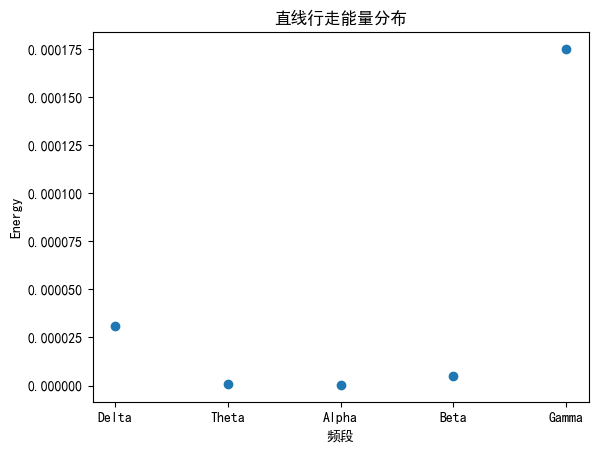

In [138]:
iter_freqs = [
    {'name': 'Delta', 'fmin': 0, 'fmax': 4},
    {'name': 'Theta', 'fmin': 4, 'fmax': 8},
    {'name': 'Alpha', 'fmin': 8, 'fmax': 13},
    {'name': 'Beta', 'fmin': 13, 'fmax': 35},
    {'name': 'Gamma', 'fmin': 35, 'fmax': 100}
    ]

plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
mne.set_log_level(False)

maxlevel = 6
fs = 128
wp = pywt.WaveletPacket(data=data.iloc[1,:], wavelet='db4', mode='symmetric', maxlevel=8)

freqTree = [node.path for node in wp.get_level(6, 'freq')]

  # 计算maxlevel最小频段的带宽
freqBand = fs / (2 ** maxlevel)
    # 定义能量数组
energy = []
for iter in range(len(iter_freqs)):
        iterEnergy = 0.0
        for i in range(len(freqTree)):
            # 第i个频段的最小频率
            bandMin = i * freqBand
            # 第i个频段的最大频率
            bandMax = bandMin + freqBand
            # 判断第i个频段是否在要分析的范围内
            if (iter_freqs[iter]['fmin'] <= bandMin and iter_freqs[iter]['fmax'] >= bandMax):
                # 计算对应频段的累加和
                iterEnergy += pow(np.linalg.norm(wp[freqTree[i]].data, ord=None), 2)
        # 保存四个频段对应的能量和
        energy.append(iterEnergy)
hex_blue = '#002fc6'
plt.plot([xLabel['name'] for xLabel in iter_freqs], energy, lw=0, marker='o',)
plt.title('直线行走能量分布')
plt.ylabel('Energy')
plt.xlabel('频段')
plt.savefig("wf_energy_distribution.png", dpi=500, bbox_inches='tight')

plt.show()

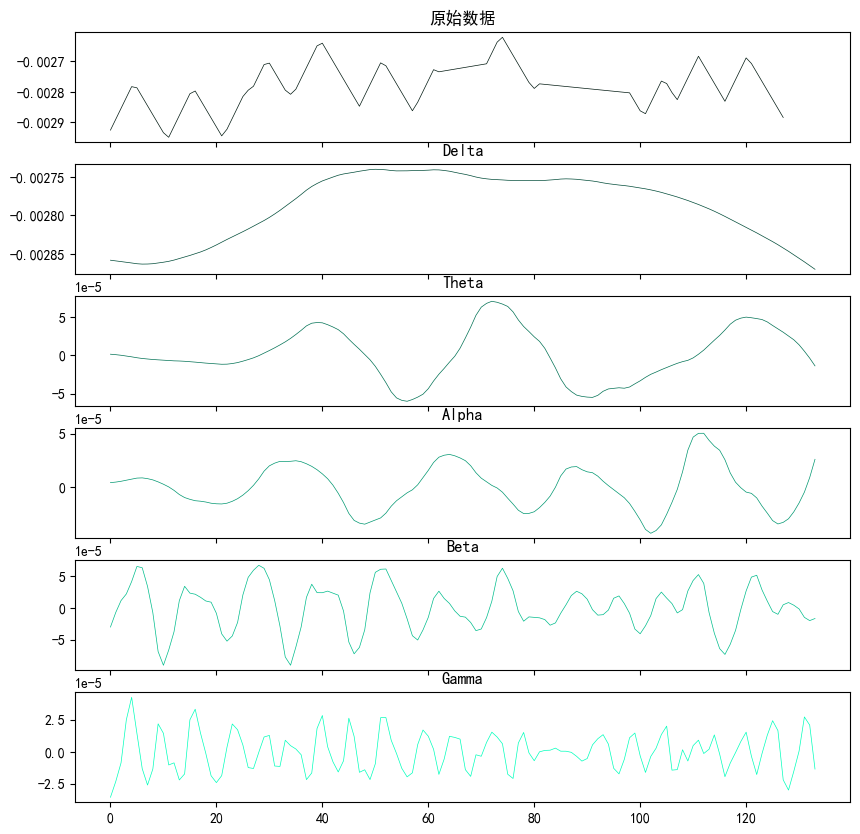

In [139]:
wp = pywt.WaveletPacket(data=data.iloc[:,28], wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
# 频谱由低到高的对应关系，这里需要注意小波变换的频带排列默认并不是顺序排列，所以这里需要使用’freq‘排序。
freqTree = [node.path for node in wp.get_level(maxlevel, 'freq')]
# 计算maxlevel最小频段的带宽
freqBand = fs/(2**maxlevel)
#######################根据实际情况计算频谱对应关系，这里要注意系数的顺序
# 绘图显示
fig, axes = plt.subplots(len(iter_freqs)+1, 1, figsize=(10, 10), sharex=True, sharey=False)
# 绘制原始数据
axes[0].plot(data.iloc[:,28], color='#001810', lw=0.5)
axes[0].set_title('原始数据')
for iter in range(len(iter_freqs)):
    # 构造空的小波包
    new_wp = pywt.WaveletPacket(data=None, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
    for i in range(len(freqTree)):
        # 第i个频段的最小频率
        bandMin = i * freqBand
        # 第i个频段的最大频率
        bandMax = bandMin + freqBand
        # 判断第i个频段是否在要分析的范围内
        if (iter_freqs[iter]['fmin']<=bandMin and iter_freqs[iter]['fmax']>= bandMax):
            # 给新构造的小波包参数赋值
            new_wp[freqTree[i]] = wp[freqTree[i]].data
    # 绘制对应频率的数据
    hex_greens = ['#004b38','#007154','#009770','#00bd8c','#00ffbc']
    axes[iter+1].plot(new_wp.reconstruct(update=True),hex_greens[iter], lw=0.5)
        # 设置图名
    axes[iter+1].set_title(iter_freqs[iter]['name'])
    plt.savefig("eeg_wavelet.png", dpi=500, bbox_inches='tight')
plt.ylabel('幅值（μV）')
plt.xlabel('直线行走')
plt.show()